### 1. Make classification data and get it ready

Use the `make_circles()` of scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42 # keep random state so we get the same values
)

In [2]:
print(f"First 5 X features:\n {X[:5]}")
print(f"\nFirst 5 y labels:\n {y[:5]}")

First 5 X features:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
 [1 1 1 1 0]


Let's keep following the data explorer's motto of visualize, visualize, visualize and put them into a pandas DataFrame.

In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


This tells us that our problem is `binary classification` since there's only two options (0 or 1).

How many values of each class are there?

In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

Plot them

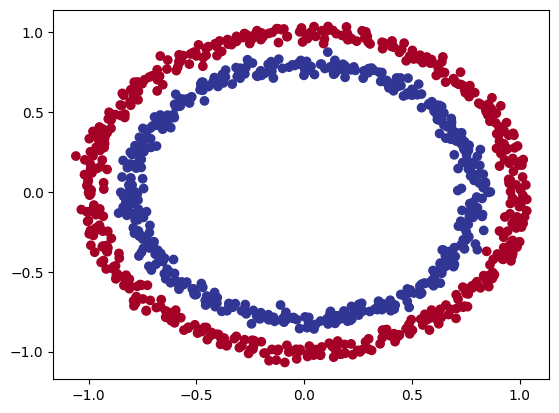

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=y,
    cmap=plt.cm.RdYlBu
)

#### 1.1 Input and output shapes

One of the `most common` errors in deep learning is shape errors.

What you can do instead is `continually familiarize yourself` with the shape of the data you're working with.

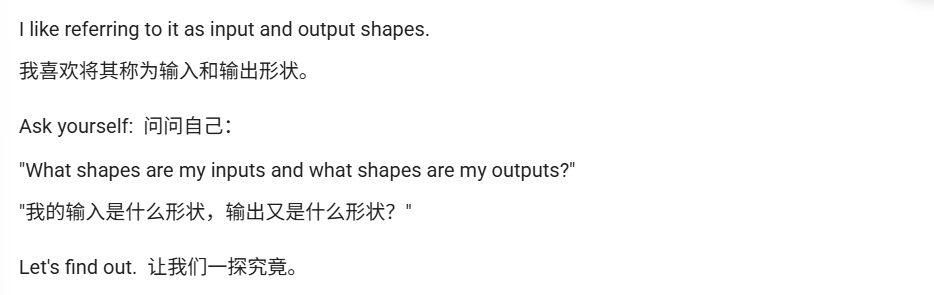

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

But what's the second dimension on `X`?

It often helps to `view the values and shapes of a single sample` (features and labels).

Doing so will `help you understand what input and output shapes` you'd be expecting from your model.

In [7]:
# View the first example of features and labels
X_sample, y_sample = X[0], y[0]
print(f"Values for one sample of X : {X_sample} and the same for y: {y_sample}")
print(f"\n Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X : [0.75424625 0.23148074] and the same for y: 1

 Shapes for one sample of X: (2,) and the same for y: ()


This tells us the second dimension for `X` means it has two features (vector) where as `y` has a single feature (scalar)

We have two inputs for one output.

#### 1.2 Turn data into tensors and create train and test splits

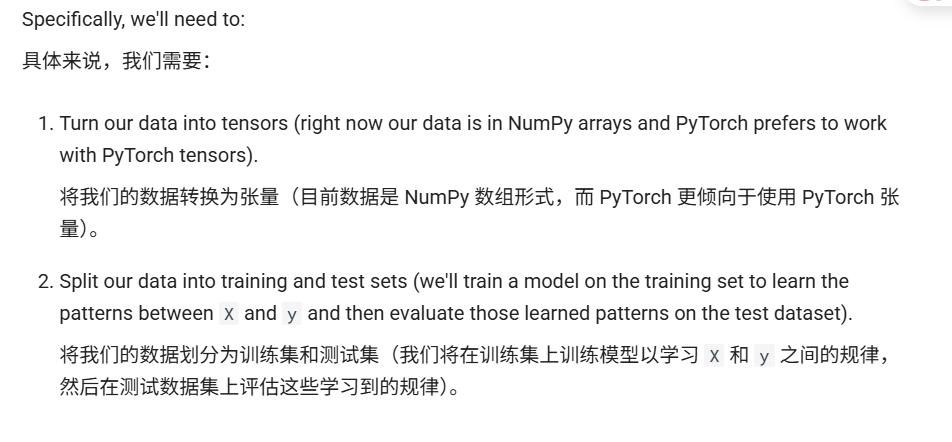

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

Next step is to split it into training and test sets

use `train_test_split()` in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Building a model

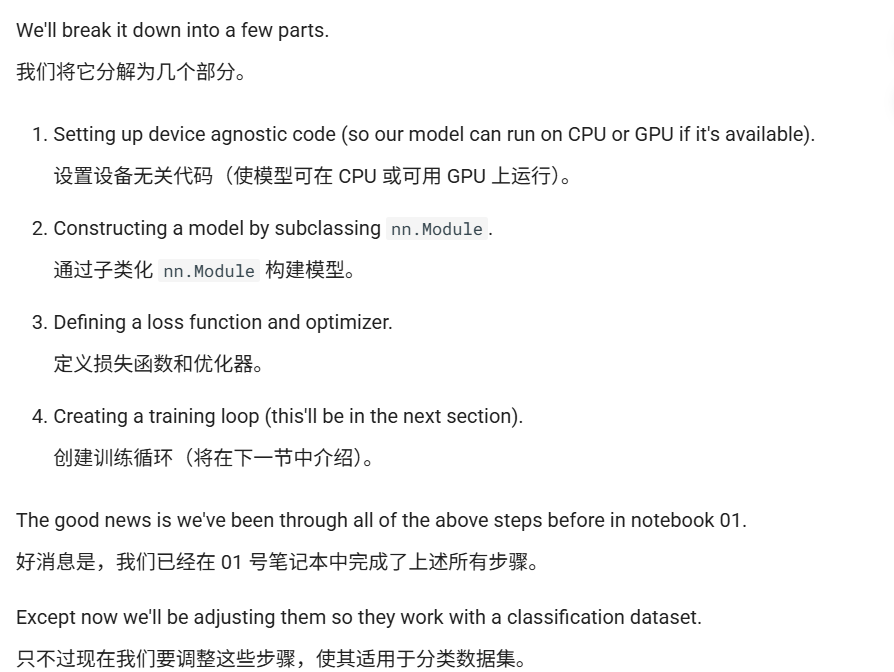

In [10]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

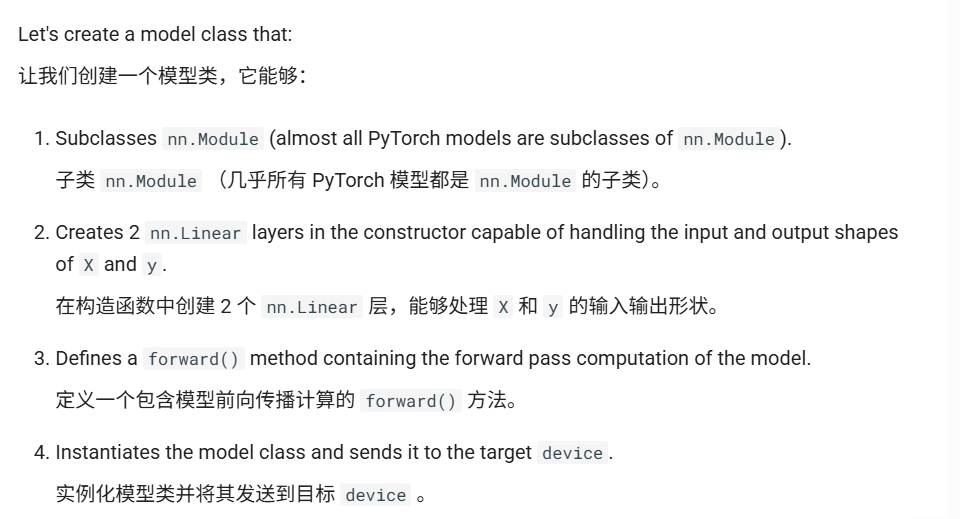

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
        
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2
    
# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0, model_0.state_dict()


(CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.5212, -0.5939],
                       [-0.3560, -0.0419],
                       [ 0.0010, -0.0174],
                       [ 0.6980,  0.1308],
                       [-0.3842,  0.0414]], device='cuda:0')),
              ('layer_1.bias',
               tensor([ 0.6172, -0.2490, -0.0601,  0.2921, -0.4045], device='cuda:0')),
              ('layer_2.weight',
               tensor([[ 0.2893,  0.2924, -0.1513,  0.1649, -0.3619]], device='cuda:0')),
              ('layer_2.bias', tensor([0.1711], device='cuda:0'))]))

Now we've got a model, let's see what happens when we pass some data through it.

In [12]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\n First 10 predictions: \n {untrained_preds[:10]}")
print(f"\n First 10 test labels: \n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

 First 10 predictions: 
 tensor([[0.2484],
        [0.3173],
        [0.3242],
        [0.2258],
        [0.7315],
        [0.7704],
        [0.6417],
        [0.7489],
        [0.3069],
        [0.3264]], device='cuda:0', grad_fn=<SliceBackward0>)

 First 10 test labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### 2.1 Create Loss function and optimizer

In [13]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

Now let's also create an `evaluation metric`

evaluation metrics as measuring how *right* it is.

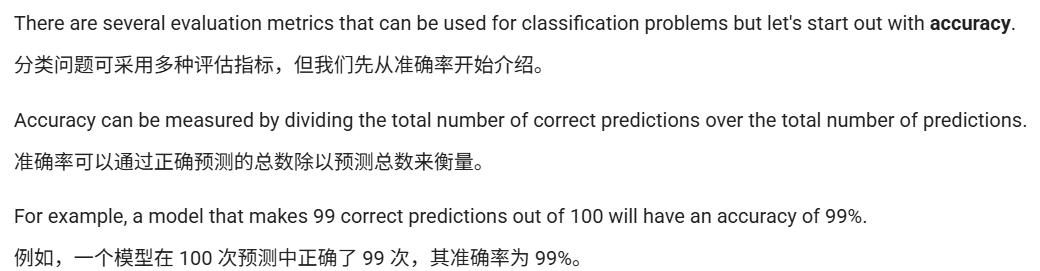

In [14]:
# Calculate accuracy (a classificaion metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### 3. Training model 

#### 3.1 Going from raw model outputs ro predicted labels (logits -> prediction probabilities -> prediction labels)

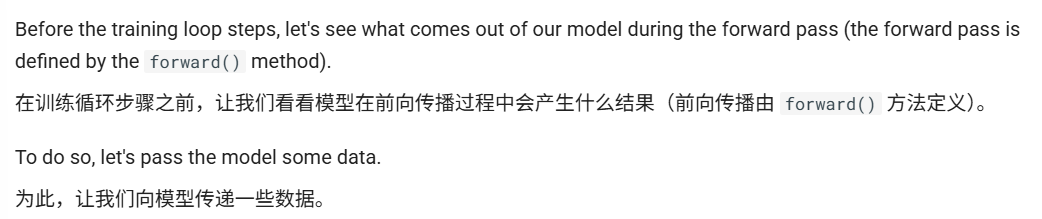

In [15]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2484],
        [0.3173],
        [0.3242],
        [0.2258],
        [0.7315]], device='cuda:0', grad_fn=<SliceBackward0>)

the raw outputs of our model are often referred to as **logits**.

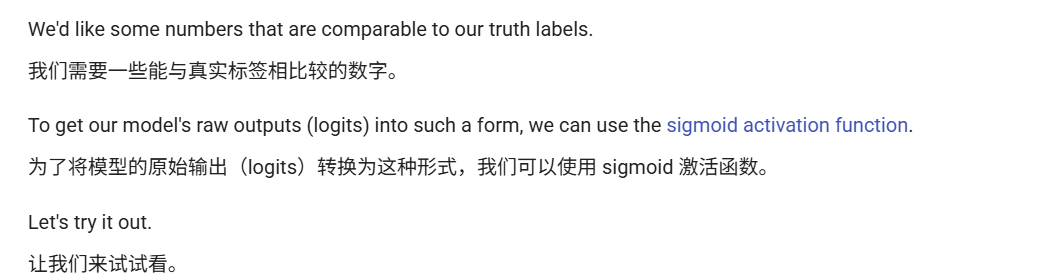

In [16]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5618],
        [0.5787],
        [0.5804],
        [0.5562],
        [0.6751]], device='cuda:0', grad_fn=<SigmoidBackward0>)

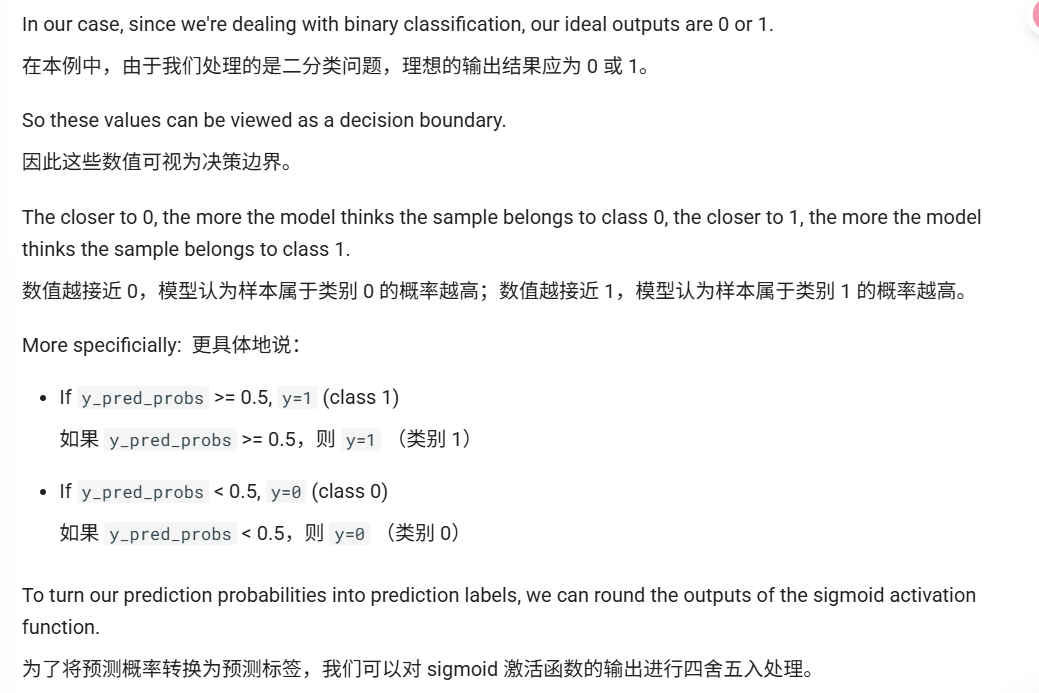

In [17]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

Excellent! Now it looks like our model's predictions are in the same form as our truth labels `(y_test)`.

In [18]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

#### 3.2 Building a training and testing loop



In [20]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
    ### Training 
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits,  # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.72821, Accuracy: 50.00% | Test loss: 0.72204, Test acc: 50.00%
Epoch: 10 | Loss: 0.70547, Accuracy: 50.00% | Test loss: 0.70269, Test acc: 50.00%
Epoch: 20 | Loss: 0.69775, Accuracy: 55.50% | Test loss: 0.69620, Test acc: 55.50%
Epoch: 30 | Loss: 0.69503, Accuracy: 54.12% | Test loss: 0.69400, Test acc: 55.50%
Epoch: 40 | Loss: 0.69404, Accuracy: 51.50% | Test loss: 0.69327, Test acc: 55.00%
Epoch: 50 | Loss: 0.69366, Accuracy: 50.25% | Test loss: 0.69304, Test acc: 54.00%
Epoch: 60 | Loss: 0.69349, Accuracy: 50.38% | Test loss: 0.69300, Test acc: 50.50%
Epoch: 70 | Loss: 0.69340, Accuracy: 50.75% | Test loss: 0.69302, Test acc: 49.00%
Epoch: 80 | Loss: 0.69334, Accuracy: 50.25% | Test loss: 0.69306, Test acc: 47.00%
Epoch: 90 | Loss: 0.69330, Accuracy: 50.50% | Test loss: 0.69311, Test acc: 45.50%


#### 4. Make predictions and evaluate the model

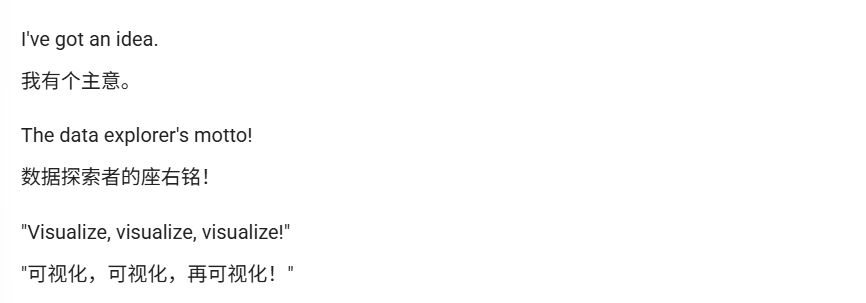

In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


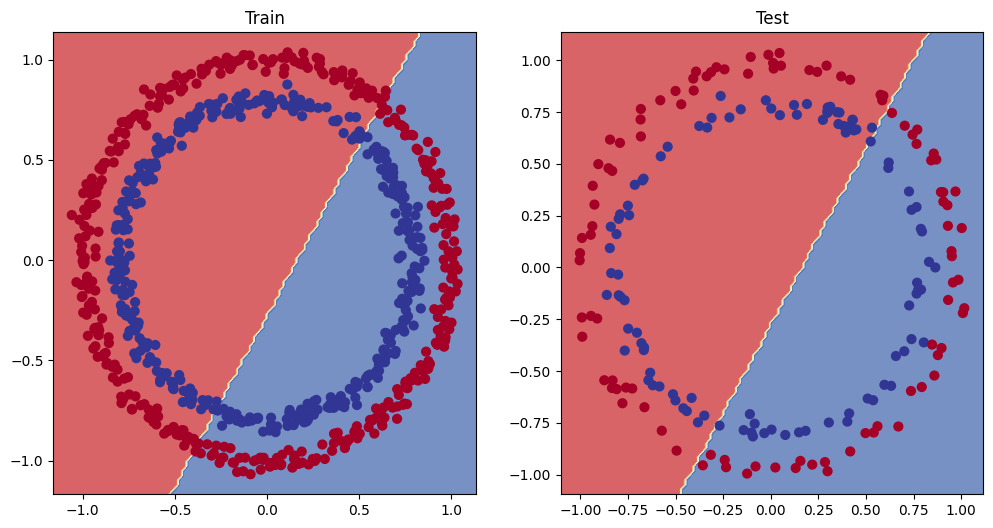

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

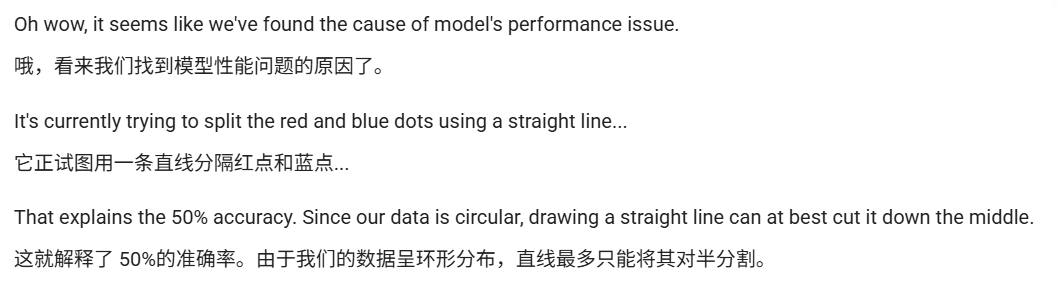

### 5. Improving a model(from a model perspective)

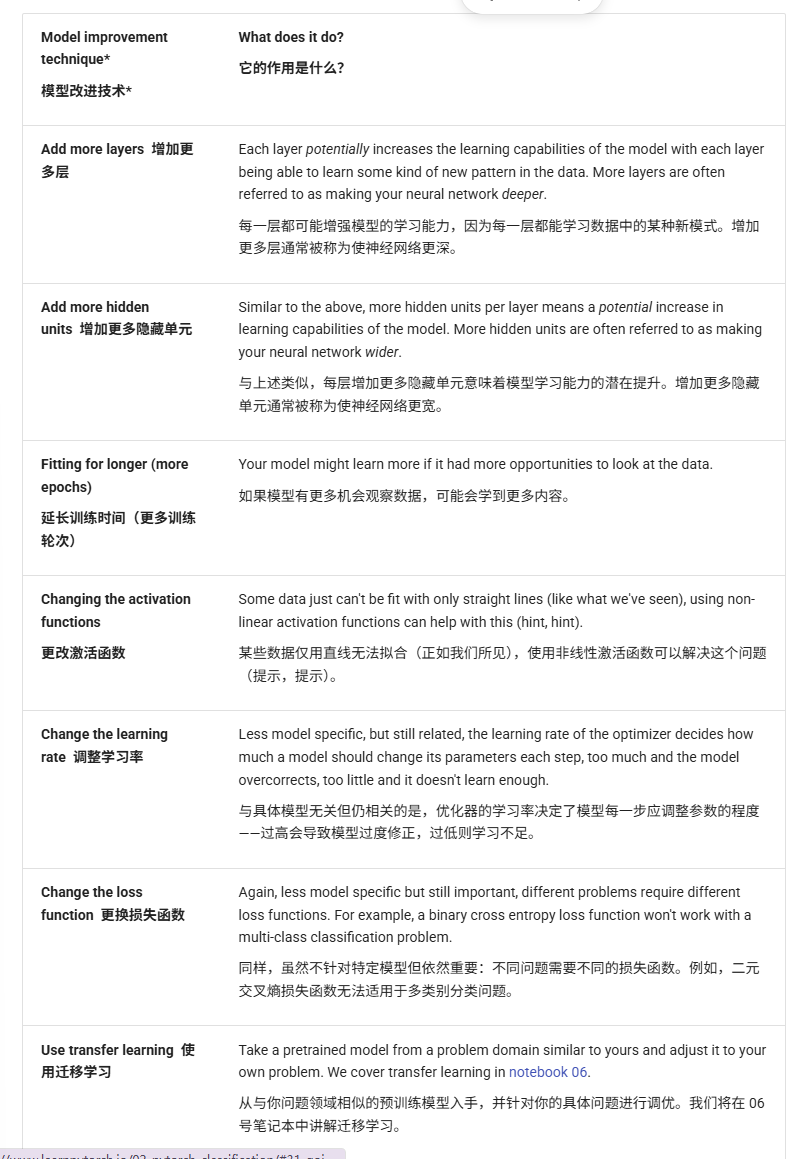

add an extra layer to our model

fit for longer

increase the number of hidden units from

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)  
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)
        return z

model_1 = CircleModelV1().to(device)
model_1, model_1.state_dict()

(CircleModelV1(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]], device='cuda:0')),
              ('layer_1.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984], device='cuda:0')),
              ('layer_2.weight',
               tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.049

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [27]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happing every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy:{acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 10 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 20 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 30 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 40 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 50 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 60 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 70 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 80 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 90 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 100 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 110 | Loss: 0.69298, Accuracy:51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 120 | Lo

What happen!

Let's visualize it

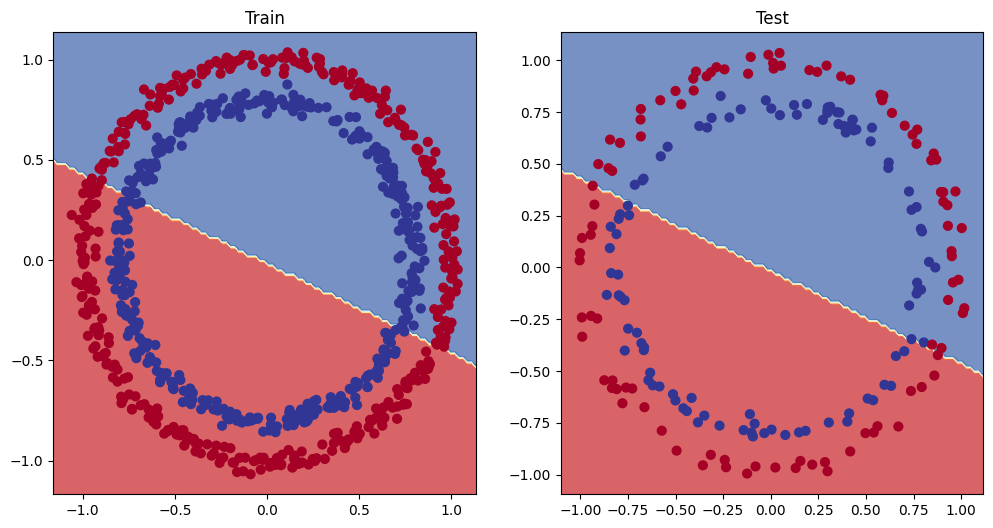

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

之后检验了 `model_1()` 是否有能拟合线性数据的能力，发现是有的，和 `01` 笔记本中记载的那样，在这我直接跳过

如果绘制非线性数据，那么模型的能力就很差

#### 6.2 Building a model with non-linearity

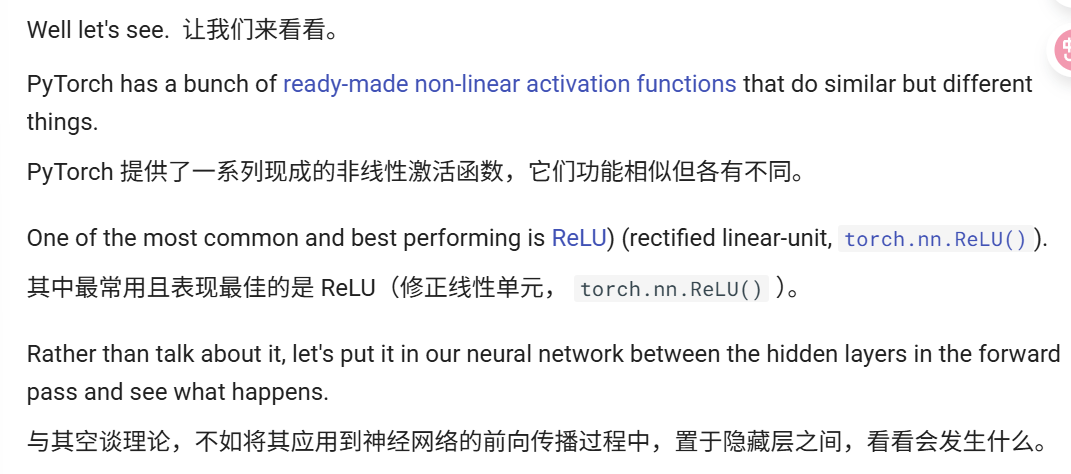

In [29]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function 

    def forward(self, x):
        z = self.layer_1(x)
        z = self.relu(z)
        z = self.layer_2(z)
        z = self.relu(z)
        z = self.layer_3(z)
        return z
    
model_3 = CircleModelV2().to(device)
model_3, model_3.state_dict()

(CircleModelV2(
   (layer_1): Linear(in_features=2, out_features=10, bias=True)
   (layer_2): Linear(in_features=10, out_features=10, bias=True)
   (layer_3): Linear(in_features=10, out_features=1, bias=True)
   (relu): ReLU()
 ),
 OrderedDict([('layer_1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]], device='cuda:0')),
              ('layer_1.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984], device='cuda:0')),
              ('layer_2.weight',
               tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.102

In [30]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

#### 6.3 Training a model with non-linearity



In [32]:
# Fit the model
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forwardpass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        # Print out what's happening
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69295 | Train Acc: 50.00% | Test Loss: 0.69319 | Test Acc: 50.00%
Epoch: 100 | Train Loss: 0.69115 | Train Acc: 52.88% | Test Loss: 0.69102 | Test Acc: 52.50%
Epoch: 200 | Train Loss: 0.68977 | Train Acc: 53.37% | Test Loss: 0.68940 | Test Acc: 55.00%
Epoch: 300 | Train Loss: 0.68795 | Train Acc: 53.00% | Test Loss: 0.68723 | Test Acc: 56.00%
Epoch: 400 | Train Loss: 0.68517 | Train Acc: 52.75% | Test Loss: 0.68411 | Test Acc: 56.50%
Epoch: 500 | Train Loss: 0.68102 | Train Acc: 52.75% | Test Loss: 0.67941 | Test Acc: 56.50%
Epoch: 600 | Train Loss: 0.67515 | Train Acc: 54.50% | Test Loss: 0.67285 | Test Acc: 56.00%
Epoch: 700 | Train Loss: 0.66659 | Train Acc: 58.38% | Test Loss: 0.66322 | Test Acc: 59.00%
Epoch: 800 | Train Loss: 0.65160 | Train Acc: 64.00% | Test Loss: 0.64757 | Test Acc: 67.50%
Epoch: 900 | Train Loss: 0.62362 | Train Acc: 74.00% | Test Loss: 0.62145 | Test Acc: 79.00%


#### 6.4 Evaluating a model trained with non-linear activation functions


In [33]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

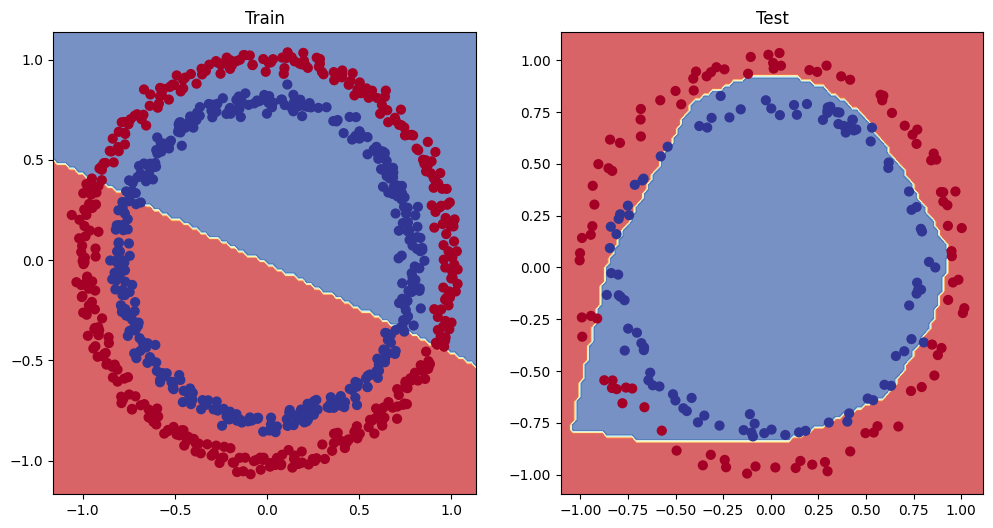

In [34]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

### 7. Replicating non-linear activation functions
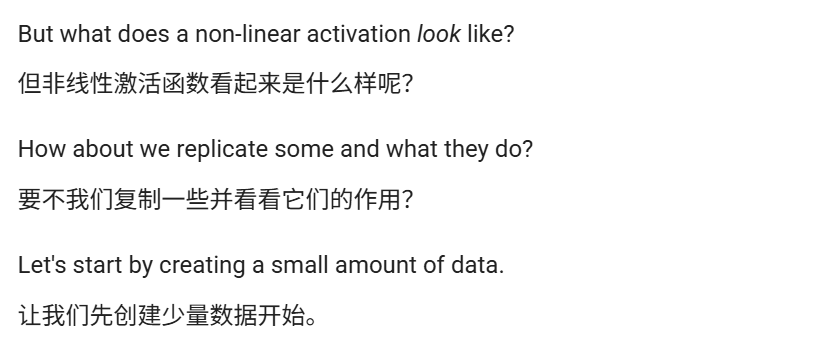

In [35]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

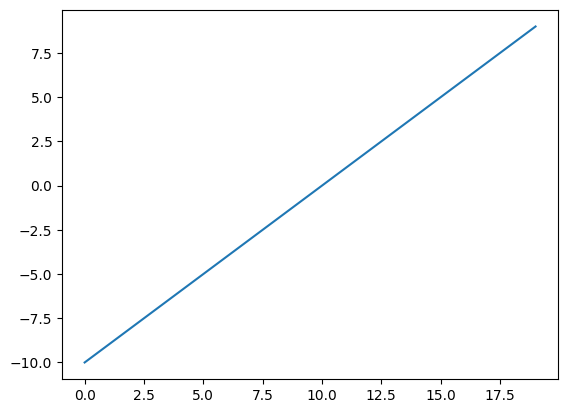

In [36]:
# Visualize to the toy tensor
plt.plot(A)

In [37]:
# Create ReLU function by hand
def relu(x):
    y = torch.maximum(torch.tensor(0), x) # input must be tensor
    return y

# Pass toy tensor through ReLU funciton
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

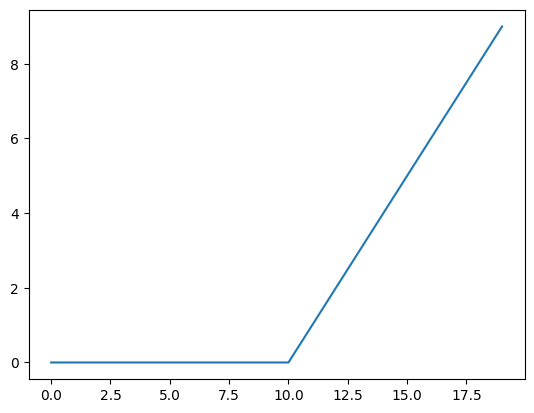

In [38]:
# Plot
plt.plot(relu(A))

Try sigmoid


In [40]:
# Create a custom sigmoid function
def sigmoid(x):
    y = 1 / (1 + torch.exp(-x))
    return y

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

# 

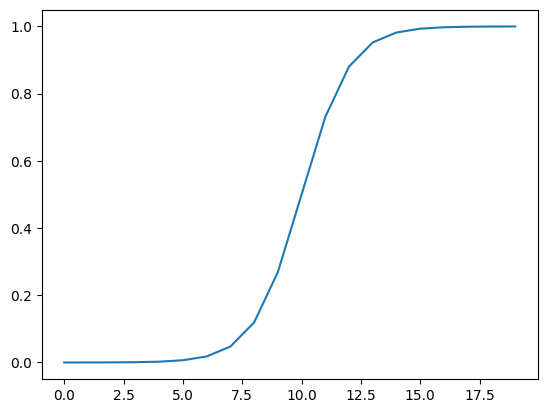

In [41]:
plt.plot(sigmoid(A))

### 8. Putting things together by building a multi-class PyTorch model

#### 8.1 Creating multi-class classification data

Use `make_blobs()` of sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

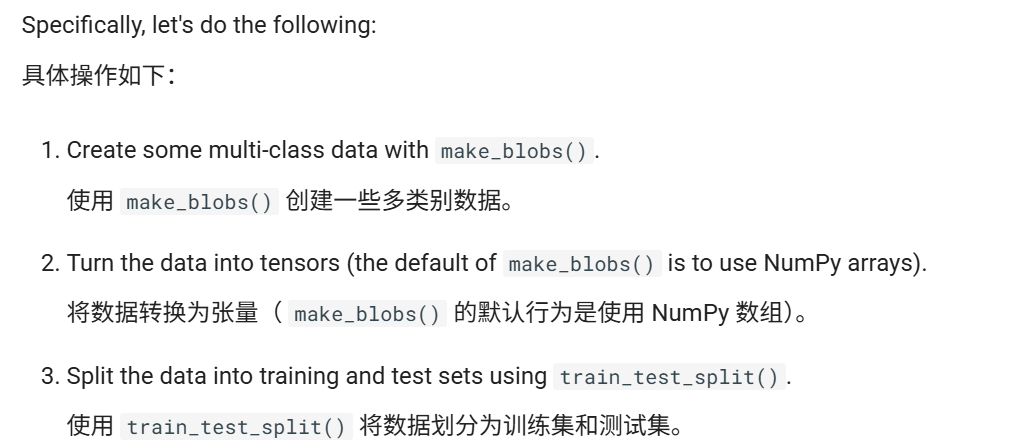

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


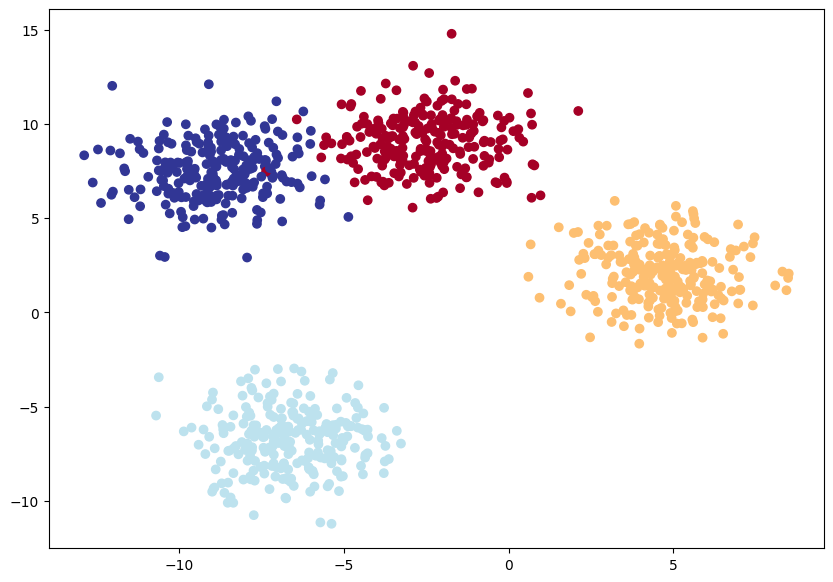

In [43]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES, # y labels
                            cluster_std=1.5, # give the clusters a little shake up 9(try changing this to 1.0, the default
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split the data into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

#### 8.2 Building a multi-class classification model in PyTorch

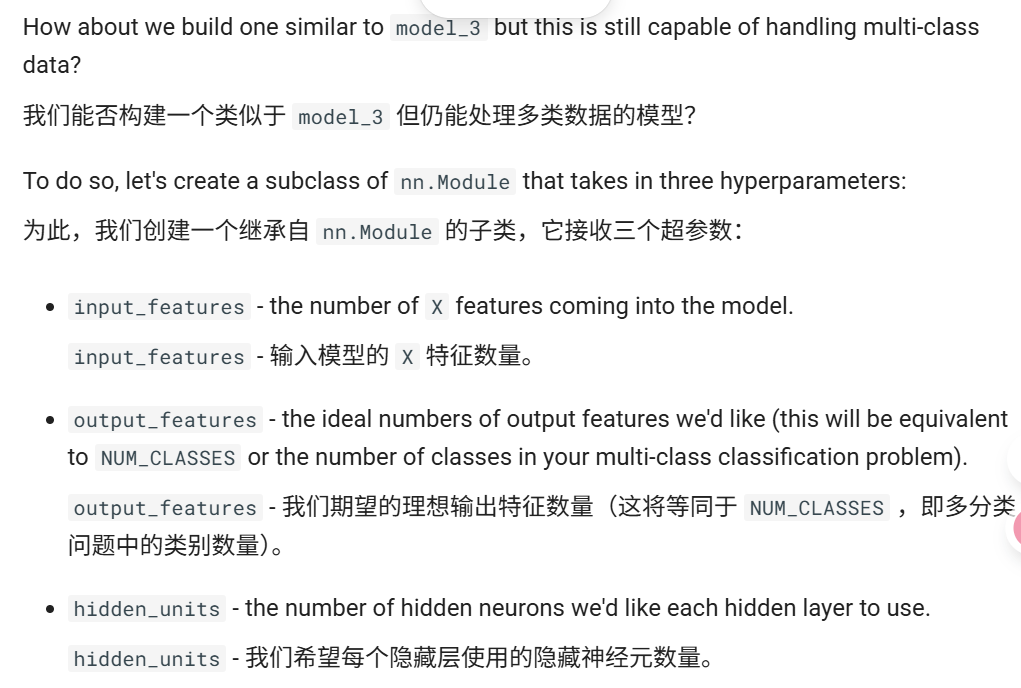

In [44]:
from torch import nn

class BlobModel(nn.Module):

    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features) # how many classes are there?
        )

    def forward(self, x):
        x = self.linear_layer_stack(x)
        return x
    
# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4, model_4.state_dict()

(BlobModel(
   (linear_layer_stack): Sequential(
     (0): Linear(in_features=2, out_features=8, bias=True)
     (1): ReLU()
     (2): Linear(in_features=8, out_features=8, bias=True)
     (3): ReLU()
     (4): Linear(in_features=8, out_features=4, bias=True)
   )
 ),
 OrderedDict([('linear_layer_stack.0.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998]], device='cuda:0')),
              ('linear_layer_stack.0.bias',
               tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691],
                      device='cuda:0')),
              ('linear_layer_stack.2.weight',
               tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003

Create a loss function and optimizer for it

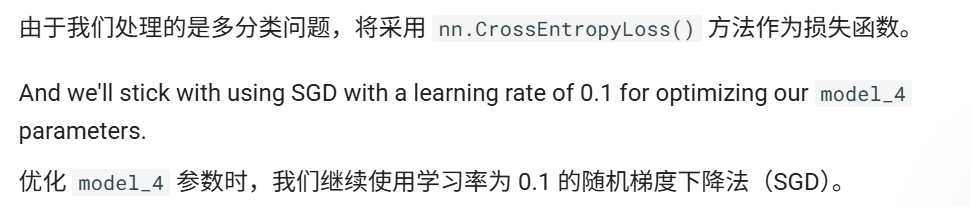

In [45]:
# Create loss and otimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

Before we do let's do a single forward pass with our model to see if it works.

In [46]:
# Perform a single forward pass on data
model_4(X_blob_train.to(device))[:5]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [50]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES, model_4(X_blob_train.to(device)).shape

(torch.Size([4]), 4, torch.Size([800, 4]))

Original output: `logits`

If we wanted to figure out exactly which label is was giving the sample?

#### Use softmax activation function

In [51]:
# Make prediction logits with model
y_logits = model_4(X_blob_train.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probability
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]], device='cuda:0',
       grad_fn=<SliceBackward0>)


After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

(tensor(1., device='cuda:0', grad_fn=<SumBackward0>),
 tensor(0.1324, device='cuda:0', grad_fn=<SelectBackward0>))

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

In [61]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3080, 0.3328, 0.1441, 0.2150], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


#### 8.5 Creating a training and testing loop for a multi-class PyTorch



In [62]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels

    # 2. calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer stop
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        model_4.eval()
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    # Print our what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_loss: {test_loss:.5f} | Test_acc: {test_acc:.2f}%" )

Epoch: 0 | Loss: 1.15883 | Acc: 40.38% | Test_loss: 1.07554 | Test_acc: 48.00%
Epoch: 10 | Loss: 0.64476 | Acc: 96.75% | Test_loss: 0.66069 | Test_acc: 97.50%
Epoch: 20 | Loss: 0.42535 | Acc: 98.50% | Test_loss: 0.43074 | Test_acc: 100.00%
Epoch: 30 | Loss: 0.25294 | Acc: 99.12% | Test_loss: 0.24508 | Test_acc: 99.50%
Epoch: 40 | Loss: 0.11232 | Acc: 99.25% | Test_loss: 0.10229 | Test_acc: 99.50%
Epoch: 50 | Loss: 0.06627 | Acc: 99.25% | Test_loss: 0.05848 | Test_acc: 99.50%
Epoch: 60 | Loss: 0.05068 | Acc: 99.25% | Test_loss: 0.04293 | Test_acc: 99.50%
Epoch: 70 | Loss: 0.04300 | Acc: 99.25% | Test_loss: 0.03491 | Test_acc: 99.50%
Epoch: 80 | Loss: 0.03836 | Acc: 99.25% | Test_loss: 0.02988 | Test_acc: 99.50%
Epoch: 90 | Loss: 0.03525 | Acc: 99.25% | Test_loss: 0.02663 | Test_acc: 99.50%


Good! To make sure these, we make some predictions and visualize them.

In [64]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
# view the first 10 predictions
y_logits[:10]

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


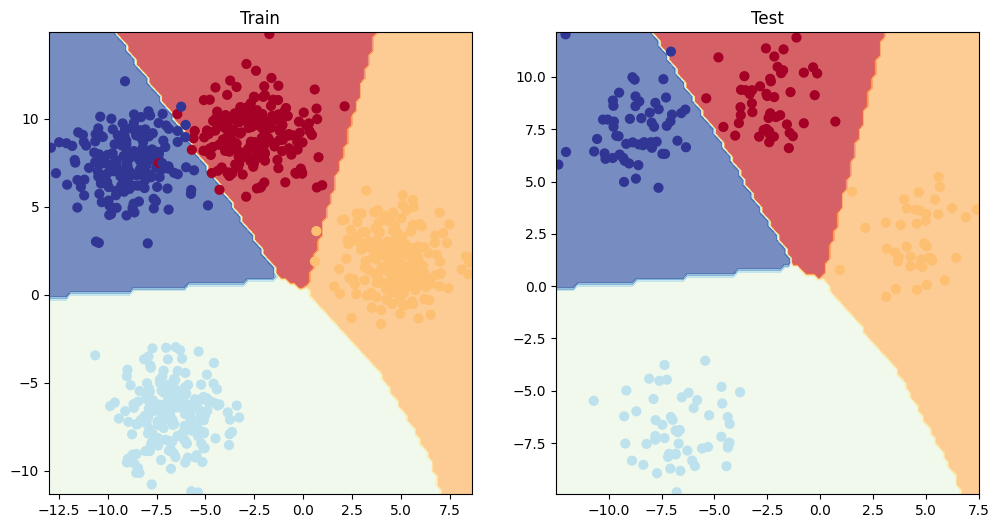

In [65]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

More classification evaluation metrics

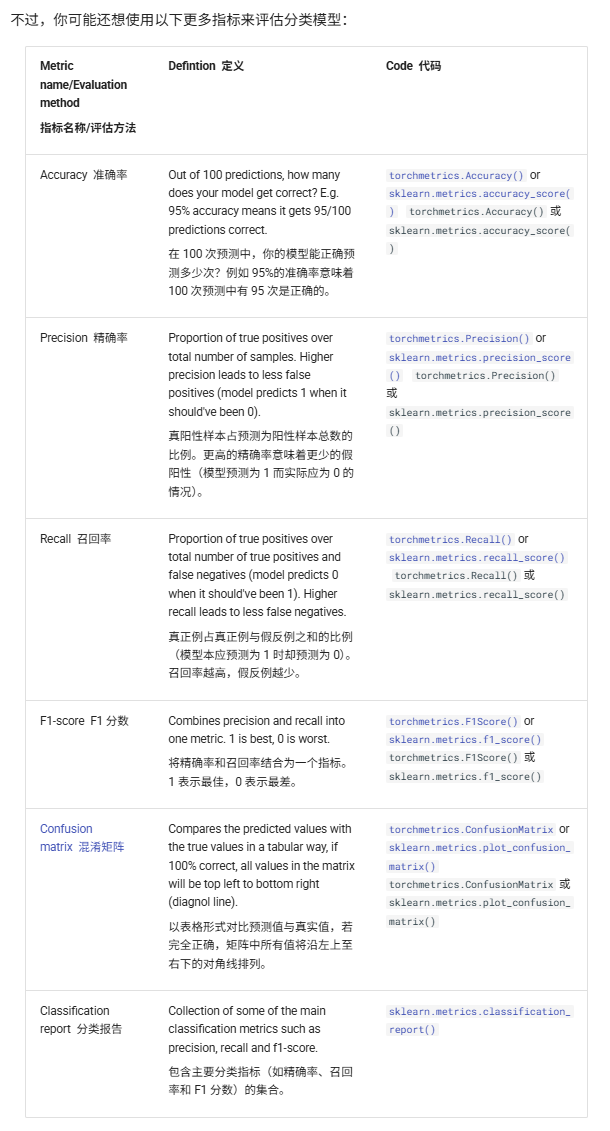

In [68]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)


tensor(0.9950, device='cuda:0')